/home/camilalm/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Samples shape: (2062, 64, 64)
Labels shape: (2062, 10)

Training shape: (1752, 64, 64)
1752 sample, 64 x 64 size grayscale image.



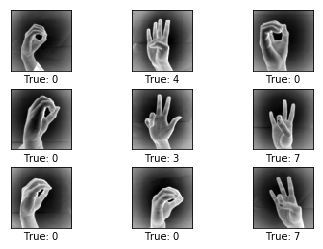

Test shape: (310, 64, 64)
310 sample, 64 x 64 size grayscale image.



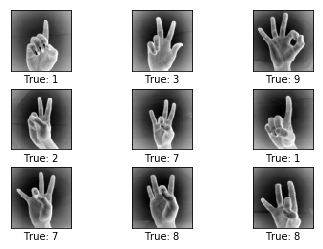

In [1]:
# Configura conjuntos de treinamento e teste 
# X_train, X_test, Y_train, Y_test
%run './functions/SLD-LoadTrainTestSets.ipynb'

In [2]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Model, Input
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D, GlobalAveragePooling2D, Reshape
from keras.optimizers import Adam

In [3]:
original_input_shape = (64, 64, 3)
desired_input_shape = (64, 64, 1)
layer_name = 'conv1'

weights = None
include_top = False

adam_lr = 0.0001
nb_epochs = 10
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
validation_split = 0.1
batch_size=10

---

In [4]:
# Configuração necessária para imagens 64x64
weights = None
include_top = False

In [5]:
base_model = MobileNet(input_shape=original_input_shape,
                       weights=weights,
                       include_top=include_top)
base_model.layers[-1].name

'conv_pw_13_relu'

In [6]:
# Alterando input para grayscale (1 channel)
selected_layer = base_model.get_layer(layer_name)
selected_layer_index = base_model.layers.index(selected_layer)

w = selected_layer.get_weights()
w[0] = w[0].mean(axis=2, keepdims=True)

y = x = Input(shape=desired_input_shape)

attributes = dict(selected_layer.get_config(),
                  name=layer_name + '_1',
                  weights=w)
selected_layer = Conv2D.from_config(attributes)

y = selected_layer(y)

for layer in base_model.layers[selected_layer_index + 1:]:
    y = layer(y)

In [7]:
# Adicionando camadas representadas pelo include_top=True
# camada FC no final da rede
y = GlobalAveragePooling2D()(y)
y = Reshape((1, 1, 1024))(y)
y = Dropout(0.25)(y)
y = Conv2D(10, kernel_size=(1, 1), activation='relu')(y)
y = Activation('softmax')(y)
y = Reshape((10,))(y)

In [8]:
model = Model(inputs=x, outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 31, 31, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization multiple                  128       
_________________________________________________________________
conv1_relu (Activation)      multiple                  0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   multiple                  0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  multiple                  288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza multiple                  128       
__________

In [9]:
expand_train_X = np.expand_dims(X_train, axis=-1)
expand_test_X = np.expand_dims(X_test, axis=-1)

Train on 1576 samples, validate on 176 samples
Epoch 1/10
1576/1576 [==============================] - 56s 35ms/step - loss: 2.3029 - acc: 0.1294 - val_loss: 2.2968 - val_acc: 0.1534
Epoch 2/10
1576/1576 [==============================] - 92s 58ms/step - loss: 2.2638 - acc: 0.1643 - val_loss: 2.2690 - val_acc: 0.1591
Epoch 3/10
1576/1576 [==============================] - 83s 53ms/step - loss: 2.2249 - acc: 0.1777 - val_loss: 2.2214 - val_acc: 0.1875
Epoch 4/10
1576/1576 [==============================] - 69s 44ms/step - loss: 2.1423 - acc: 0.2398 - val_loss: 2.2284 - val_acc: 0.2102
Epoch 5/10
1576/1576 [==============================] - 73s 46ms/step - loss: 2.0506 - acc: 0.2824 - val_loss: 2.1985 - val_acc: 0.2273
Epoch 6/10
1576/1576 [==============================] - 72s 46ms/step - loss: 1.9727 - acc: 0.3058 - val_loss: 2.1613 - val_acc: 0.2386
Epoch 7/10
1576/1576 [==============================] - 77s 49ms/step - loss: 1.8772 - acc: 0.3420 - val_loss: 2.3557 - val_acc: 0.2386
E

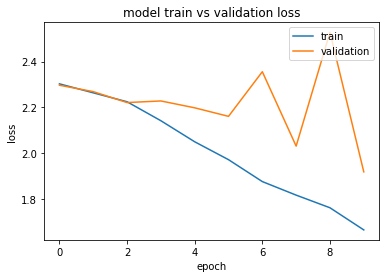

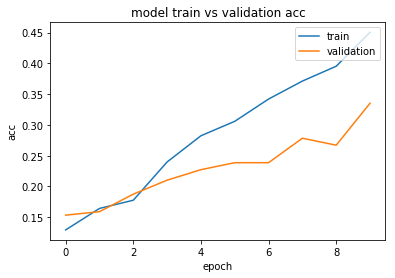

Acertos: 104 / 310
Confusion matrix, without normalization
[[24  2  0  0  2  1  0  3  0  0]
 [ 2 13  0  3  0  0  0  4  2  0]
 [ 3  6  0 10  2  0  0 11  2  0]
 [ 0  2  0 20  3  5  0  0  0  0]
 [ 3  0  0  6  7  3  0  6  4  1]
 [ 1  0  0 12  2 17  0  2  1  0]
 [ 0  1  0  8  9  0  0  8  1  1]
 [ 1  5  0  6  7  1  0 17  5  0]
 [ 6  3  0  3  2  0  0  8  6  0]
 [ 1  0  0  7  6  4  0  5  4  0]]
CPU times: user 31min 46s, sys: 3min 57s, total: 35min 44s
Wall time: 11min 49s


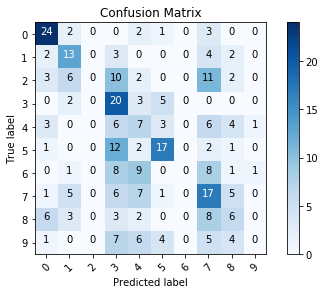

In [10]:
%%time
acertos, pred = execute_model(model, expand_train_X, Y_train, expand_test_X, Y_test,
                              validation_split, batch_size, cm_plot_labels, 
                              adam_lr, nb_epochs)

---